In [334]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt

In [335]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [336]:
pars.set_matter_power(redshifts=[3], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [337]:
def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale

In [338]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [339]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

Derivata composta della distanza cìdi luminosità

dr/dz =  c/H

dl = (1+z)*r 

dl'= r + (1+z)*c/H

In [340]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!

f = (results.get_fsigma8()/results.get_sigma8())
dl = results.luminosity_distance(z[0])
d= results.comoving_radial_distance(z[0])
 

fl= (2*d)/(d+(1+z[0])*2.99e5/H(z[0]))

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [341]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = float((bias + fl *f * mu[j]**2)**2*pk[:,i])


In [342]:
#Dati per la funzione teorica

om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.9502715365595552

In [343]:
print(f)
print(fl)
print(fl*f)
print(omz**0.545)

[0.97685751]
1.233320896647028
[1.20477878]
0.9725837475518058


In [344]:
##Errori dei dati simulati
ng= 15e-4   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol*1/(2*np.pi)**2 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [345]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.04595822151301339

In [346]:
#faccio una trasformata di fuorier: considero il volume del guscio sferico come il volume di un cubo

Diag = np.sqrt(3) * (64)**(1/3)
2*np.pi/Diag

0.906899682117109

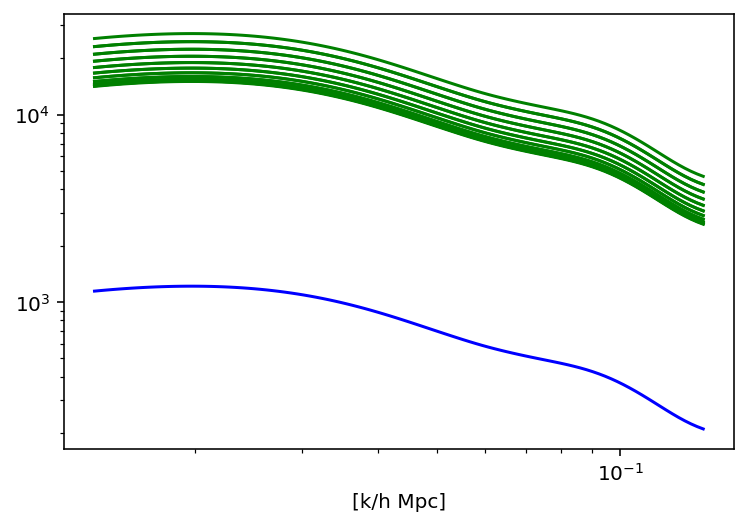

In [347]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[2368.61723882 2329.98891851 2291.15379575 2252.12226877 2212.90576536
 2173.51462444 2133.95848861 2094.24830875 2054.39637594 2014.4154429
 1974.31812689 1934.11831909 1893.83129979 1853.47312856 1813.05918273
 1772.60584288 1732.13092576 1691.6534842  1651.19282488 1610.76909226
 1570.40373474 1530.11939954 1489.93940143 1449.88770626 1409.98929552
 1370.27008364 1330.75727076 1291.4795669  1252.4662016  1213.74670099
 1175.35144267 1137.31336846 1099.66554585 1062.44034835 1025.66989958
  989.39002852  953.63715846  918.44555457  883.84748619  849.87825149
  816.57525174  783.97213753  752.09866259  720.985476    690.66793826
  661.17655411  632.53601873  604.76789528  577.89780917  551.94694561
  526.92968091  502.85542313  479.73920227  457.59475215  436.42810262
  416.23826814  397.01417475  378.73606956  361.38117018  344.9244929
  329.34733443  314.64503961  300.8098487   287.82938166  275.67342548
  264.27194361  253.55469589  243.45846672  233.92584866  224.90447055
  216.34

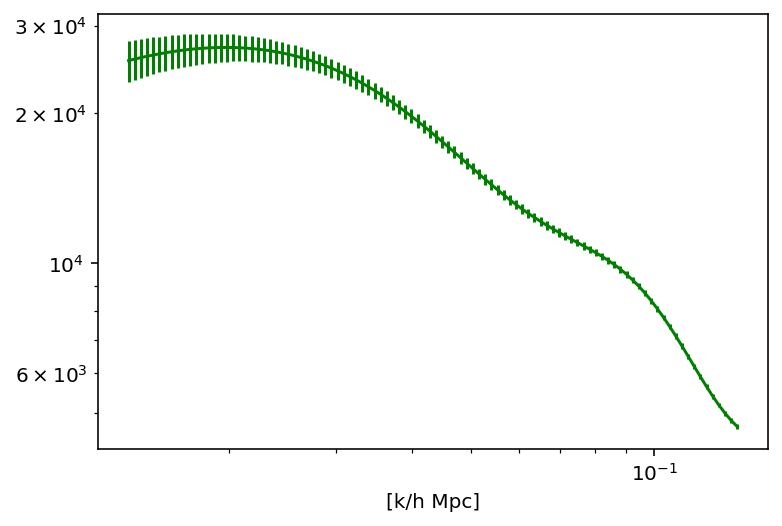

In [348]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [349]:
gammas= np.arange(0,10,0.05)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



Text(0, 0.5, 'Chi^2')

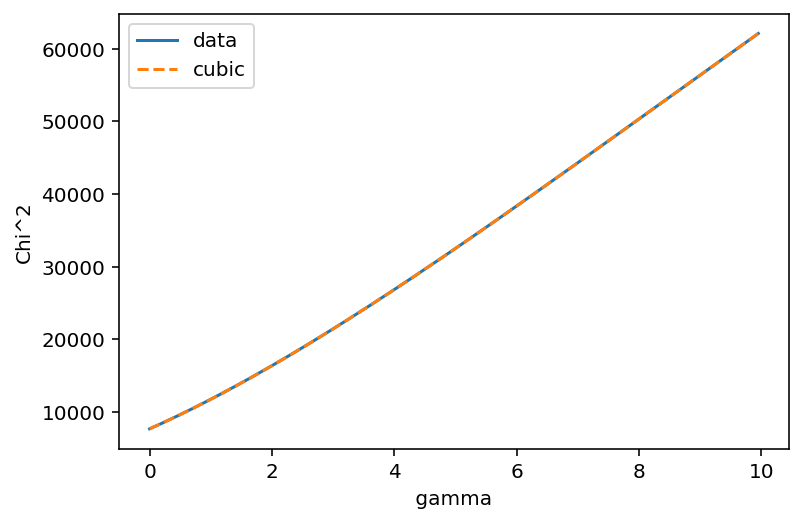

In [350]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])
plt.xlabel(' gamma ')
plt.ylabel('Chi^2')


#plt.axis([0.54,0.56,0,3])

In [351]:
type(interpol)
y=lambda x: interpol(x)


In [352]:

minimo = optimize.least_squares(y,0.55)
min1= float(minimo.x)
minimo

ValueError: A value in x_new is below the interpolation range.

In [ ]:
chi2min= y(min1)

In [ ]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

1.25

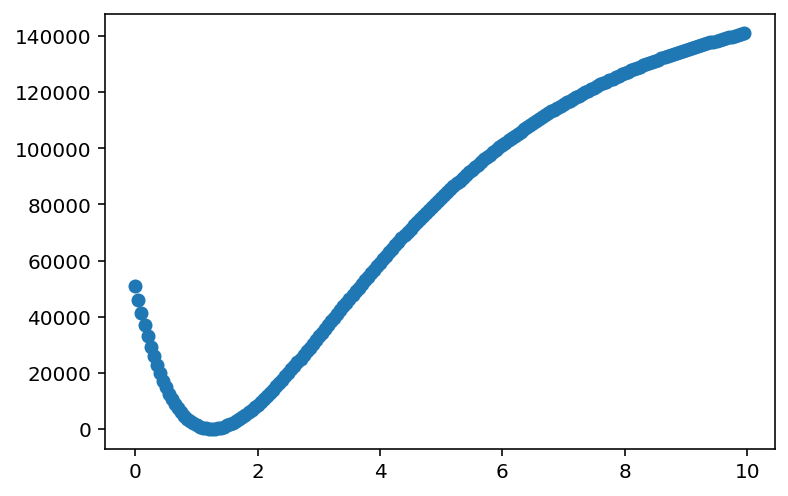

In [ ]:
plt.scatter(gammas,chi2)

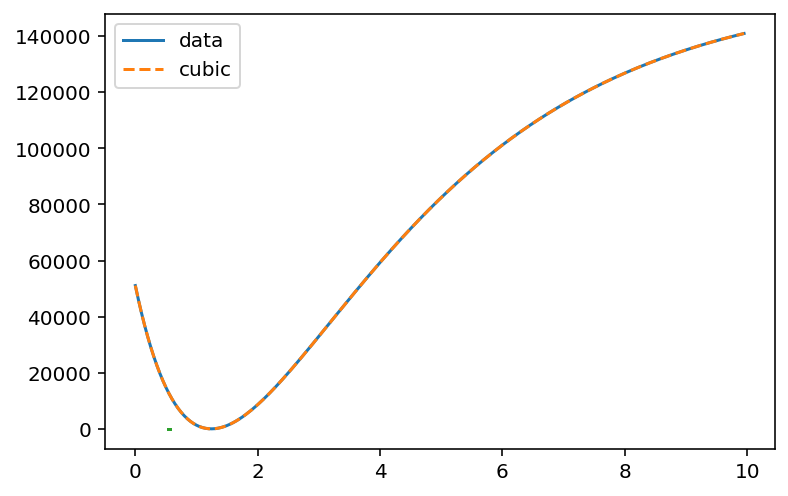

In [ ]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.54,0.56,0.001)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [ ]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.54,0.55)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,0.55,0.56)
print(error1,error2)

ValueError: f(a) and f(b) must have different signs

In [ ]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.006

0.00594454042159398
0.005979624877317069


In [ ]:
print("Il valore di gamma trovat è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovat è:  0.549  +-  0.006


In [ ]:
#facciamo il fit, posso usare optimize perché ho l'errore su una sola variabile

#def func(i, gamma):
#    return (bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]
#
#index = np.array(0,len(kh),1)
#popt, pcov = optimize.curve_fit(func, index , Pgg[:,?], err_Pgg)  #non so che fare con ste mu
